
### url for challenge : https://www.hackerearth.com/challenges/competitive/garden-nerd-data-science-competition/

In [0]:
# !wget https://he-public-data.s3-ap-southeast-1.amazonaws.com/HE_Challenge_data.zip

In [0]:
# !unzip HE_Challenge_data

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


## Data Pipeline

In [0]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample_submission.csv')

In [7]:
train.tail(3)

,image_id,category
18537,18537,78
18538,18538,74
18539,18539,29


In [9]:
test.head(3)

,image_id,category
0,18540,NaN
1,18541,NaN
2,18542,NaN


In [10]:
sample.head(3)

,image_id,category
0,18540,0
1,18541,0
2,18542,0


In [0]:
train = train.values

In [0]:
folders, num_samples = np.unique(train[:, 1], return_counts=True)

In [0]:
for folder in folders:
  p = os.path.join('data/train', str(folder))
  if not os.path.isdir(p):
    os.mkdir(p)

In [0]:
# make subdirectory of each class
for i in range(train.shape[0]):
  dest = os.path.join('data/train/', str(train[i][1]))
  src = os.path.join('data/train', str(train[i][0]) + '.jpg')
  shutil.move(src, dest)

#### validation - training split

In [0]:
SPLIT = 0.90 # 90% for training 10% for validation

In [0]:
# create the validation directory
if not os.path.isdir('data/val'):
  os.mkdir('data/val')


In [0]:
# creating subdirectories (of each category) in validation directory
for folder in folders:
  p = os.path.join('data/val', str(folder))
  if not os.path.isdir(p):
    os.mkdir(p)


In [0]:
# move the 10% data from training directory to validation directory

for f in folders:
  path = 'data/train/'+str(f)
  imgs = os.listdir(path)
  split_size = int(SPLIT*len(imgs))
  file_to_move = imgs[split_size:]
  
  for img_f in file_to_move:
    src = os.path.join(path, img_f)
    dest = os.path.join('data/val/'+str(f), img_f)
    shutil.move(src, dest)


###Data Augmentation


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
train_img_gen = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.4,
    zoom_range = 0.3,
    horizontal_flip = True
)
val_img_gen = ImageDataGenerator(
    rescale = 1/255.0,
)

In [49]:
train_gen = train_img_gen.flow_from_directory(
    'data/train',
    batch_size = 32,
    

)
val_gen = val_img_gen.flow_from_directory(
    'data/val/',
)

Found 16638 images belonging to 102 classes.
Found 1902 images belonging to 102 classes.


In [24]:
for (x, y) in train_gen:
  print(x.shape, y.shape)
  break

(128, 256, 256, 3) (128, 102)


##  Claasifier Model - EfficientNet


In [0]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

####  Callback and Checkpoints


In [0]:
from tensorboardcolab import *

In [27]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://2f310b24.ngrok.io


In [0]:
from keras.callbacks import Callback, TensorBoard, EarlyStopping

In [0]:
# os.mkdir('logs')

In [0]:
tb = TensorBoard('./logs')
es = EarlyStopping(monitor='val_acc', min_delta=0.1, patience=5)

### Model Architecture

In [0]:
# ! pip install keras_efficientnets
from keras_efficientnets import EfficientNetB0

In [54]:
model = EfficientNetB0((256, 256, 3), classes=102, include_top=False, weights='imagenet')

16719872/16717576 [==============================] - 1s 0us/step


In [55]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_529 (Conv2D)             (None, 128, 128, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_396 (BatchN (None, 128, 128, 32) 128         conv2d_529[0][0]                 
__________________________________________________________________________________________________
swish_396 (Swish)               (None, 128, 128, 32) 0           batch_normalization_396[0][0]    
__________________________________________________________________________________________________
depthwise_

In [0]:
### adding output layer for flower classification
av1 = GlobalAveragePooling2D()(model.output)
fc1 = Dense(256, activation='relu')(av1)
d1 = Dropout(0.25)(fc1)

av2 = GlobalAveragePooling2D()(model.output)
fc2 = Dense(128, activation='relu')(av2)
d2 = Dropout(0.25)(fc2)

fc3 = Dense(102, activation='softmax')(d2)

In [0]:
model = Model(model.input, outputs  = fc3)

In [58]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_529 (Conv2D)             (None, 128, 128, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_396 (BatchN (None, 128, 128, 32) 128         conv2d_529[0][0]                 
__________________________________________________________________________________________________
swish_396 (Swish)               (None, 128, 128, 32) 0           batch_normalization_396[0][0]    
__________________________________________________________________________________________________
depthwise_

#### compilation and training

In [0]:
adam = Adam(lr=0.00003)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [61]:
hist = model.fit_generator(train_gen, steps_per_epoch=16638//32, validation_data=val_gen, validation_steps=1902//32, epochs=20, callbacks=[TensorBoardColabCallback(tbc), tb, es])

Epoch 1/20
519/519 [==============================] - 287s 552ms/step - loss: 4.0795 - acc: 0.1672 - val_loss: 2.8862 - val_acc: 0.4299
Epoch 2/20
519/519 [==============================] - 275s 529ms/step - loss: 2.3418 - acc: 0.5320 - val_loss: 1.2294 - val_acc: 0.7652
Epoch 3/20
519/519 [==============================] - 275s 530ms/step - loss: 1.2049 - acc: 0.7564 - val_loss: 0.5456 - val_acc: 0.9005
Epoch 4/20
519/519 [==============================] - 275s 529ms/step - loss: 0.6918 - acc: 0.8575 - val_loss: 0.2688 - val_acc: 0.9561
Epoch 5/20
519/519 [==============================] - 275s 529ms/step - loss: 0.4356 - acc: 0.9075 - val_loss: 0.1739 - val_acc: 0.9711
Epoch 6/20
519/519 [==============================] - 276s 531ms/step - loss: 0.2974 - acc: 0.9365 - val_loss: 0.1030 - val_acc: 0.9840
Epoch 7/20
519/519 [==============================] - 276s 531ms/step - loss: 0.2193 - acc: 0.9512 - val_loss: 0.0695 - val_acc: 0.9914
Epoch 8/20
519/519 [============================

In [0]:
def plot_loss_accuracy():
  # plot loss
  print("training_loss =", hist.history['loss'][-1],  "   val_loss =", hist.history['val_loss'][-1])
  print("training_acc =", hist.history['acc'][-1]*100, "   val_acc =", hist.history['val_acc'][-1]*100)
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.plot(hist.history['loss'], label='training_loss')

  # plot accuracy
  plt.plot(hist.history['val_acc'], label='val_acc')
  plt.plot(hist.history['acc'], label='training_acc')
  plt.legend()
  plt.show()

training_loss = 0.15948203196550556    val_loss = 0.05280459782178389
training_acc = 96.52535227728252    val_acc = 99.0909090909091


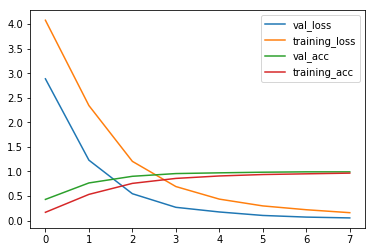

In [64]:
plot_loss_accuracy()

In [0]:
preserved_model = model

## Time to make prediction

In [0]:
if not os.path.isdir('data/test/test_data'):
  os.mkdir('data/test/test_data')

In [0]:
# make subdirectory of each class
for each in os.listdir('data/test/'):
  dest = 'data/test/test_data'
  src = os.path.join('data/test', each)
  shutil.move(src, dest)



In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [70]:
test_generator = test_datagen.flow_from_directory(
        'data/test',
        shuffle = False,
        class_mode='categorical',
        batch_size=1
)

Found 2009 images belonging to 1 classes.


In [95]:
test_generator.class_indices

{'test_data': 0}

In [0]:
filenames = test_generator.filenames

In [0]:
nb_samples = len(filenames)

In [0]:
predict = model.predict_generator(test_generator,steps = nb_samples)

In [0]:
actual_pred = np.argmax(predict, axis=1)

In [78]:
actual_pred.shape

(2009,)

In [0]:
actual_pred = actual_pred + 1 #

In [82]:
np.unique(actual_pred)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102])

In [83]:
filenames[:4]

['test_data/18540.jpg',
 'test_data/18541.jpg',
 'test_data/18542.jpg',
 'test_data/18543.jpg']

In [84]:
sample.head(4)

,image_id,category
0,18540,0
1,18541,0
2,18542,0
3,18543,0


In [0]:
sample.category = actual_pred

In [92]:
sample.tail(10)

,image_id,category
1999,20539,78
2000,20540,36
2001,20541,78
2002,20542,83
2003,20543,78
2004,20544,57
2005,20545,50
2006,20546,97
2007,20547,73
2008,20548,50


In [93]:
type(sample)

pandas.core.frame.DataFrame

In [0]:
sample.to_csv('submission.csv', index=False)